In [2]:
!pip install opendatasets
import opendatasets as od

In [53]:
import os
import random
from PIL import Image
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Input, Conv2D,MaxPooling2D,Flatten,Dense,Dropout,Resizing,Rescaling,RandomFlip,RandomRotation,RandomZoom
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from keras.models import Sequential
from keras.optimizers import Adam
import numpy as np

In [3]:
dataset_link = "https://www.kaggle.com/datasets/msambare/fer2013"
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gandpablo
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013


100%|██████████| 60.3M/60.3M [00:00<00:00, 1.22GB/s]

In [13]:
os.chdir("fer2013")
os.listdir()

['test', 'train']

In [14]:
os.listdir("train")

['sad', 'fear', 'surprise', 'angry', 'disgust', 'neutral', 'happy']

In [15]:
os.listdir("test/happy")[:5]

['PrivateTest_37370251.jpg',
 'PrivateTest_46912406.jpg',
 'PrivateTest_61167984.jpg',
 'PublicTest_69207826.jpg',
 'PublicTest_17581682.jpg']

In [17]:
count = {}

for emotion in os.listdir("train"):
    count[emotion] = [len(os.listdir("train/" + emotion))]

for emotion in os.listdir("test"):
    count[emotion].append(len(os.listdir("test/" + emotion)))

for emotion, values in count.items():
    print(f"{emotion:<10} --> {values[0]:6d}   {values[1]:6d}")

sad        -->   4830     1247
fear       -->   4097     1024
surprise   -->   3171      831
angry      -->   3995      958
disgust    -->    436      111
neutral    -->   4965     1233
happy      -->   7215     1774


In [18]:
folder = "test/neutral"
file = random.choice(os.listdir(folder))
path = os.path.join(folder, file)

img = Image.open(path)

print("Clase:", os.path.basename(folder))
print("Archivo:", file)
print("Size:", img.size)
print("Mode:", img.mode)


Clase: neutral
Archivo: PublicTest_8610634.jpg
Size: (48, 48)
Mode: L


No hay clases balanceadas, primero entrenaremos el modelo normal y luego tratando el balance de clases

In [19]:
train_dir = "train"
test_dir = "test"

training_images = image_dataset_from_directory(train_dir,
                                                color_mode='grayscale',
                                                label_mode='categorical',
                                                batch_size=32,
                                                image_size=(48,48),
                                                shuffle=True,
                                                seed=42,
                                                validation_split=0.2,
                                                subset='training')

validation_images = image_dataset_from_directory(train_dir,
                                                color_mode='grayscale',
                                                label_mode='categorical',
                                                batch_size=32,
                                                image_size=(48,48),
                                                shuffle=True,
                                                seed=42,
                                                validation_split=0.2,
                                                subset='validation')

test_images = image_dataset_from_directory(test_dir,
                                           color_mode='grayscale',
                                           label_mode='categorical',
                                           batch_size=32,
                                           image_size=(48,48),
                                           shuffle=True,
                                           seed=42)


Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [20]:
images, labels = next(iter(training_images))
print("Shape imágenes:", images.shape)
print("Shape etiquetas:", labels.shape)
print("Ejemplo etiqueta:", labels[0])

Shape imágenes: (32, 48, 48, 1)
Shape etiquetas: (32, 7)
Ejemplo etiqueta: tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)


In [21]:
class_names = training_images.class_names
print(class_names)

idx_to_emotion = {i: name for i, name in enumerate(class_names)}
print(idx_to_emotion)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


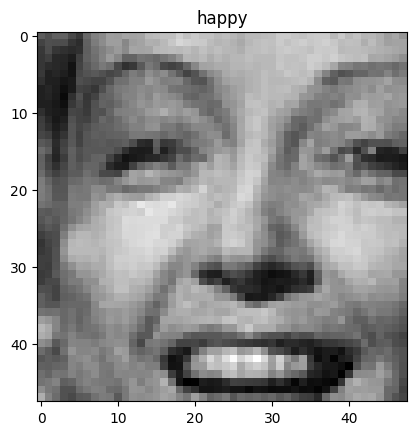

In [22]:
a = next(iter(training_images))
img = a[0].numpy()[5].astype("int")
label = a[1].numpy()[5].astype("int")

label_idx = label.argmax()
label_name = idx_to_emotion[label_idx]

plt.imshow(img, cmap='gray')
plt.title(label_name)
plt.show()

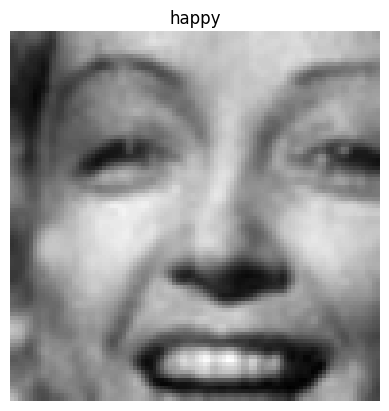

In [23]:
img_resized = tf.image.resize(img, (96, 96)).numpy().astype("int")
plt.imshow(img_resized.squeeze(), cmap="gray")
plt.title(label_name)
plt.axis("off")
plt.show()


In [24]:
modelo = Sequential()

modelo.add(Input(shape=(48,48,1)))

modelo.add(Resizing(96,96))
modelo.add(Rescaling(1./255))

modelo.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
modelo.add(MaxPooling2D(2,2))
modelo.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
modelo.add(MaxPooling2D(2,2))
modelo.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
modelo.add(MaxPooling2D(2,2))
modelo.add(Conv2D(filters=256, kernel_size=(3,3),activation='relu'))
modelo.add(MaxPooling2D(2,2))

modelo.add(Dropout(0.5))
modelo.add(Flatten())
modelo.add(Dense(256,activation='relu'))
modelo.add(Dropout(0.25))
modelo.add(Dense(128,activation='relu'))
modelo.add(Dropout(0.1))
modelo.add(Dense(7,activation='softmax'))

modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,470,471 (5.61 MB)

 Trainable params: 1,470,471 (5.61 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
class myCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nACCURACY ALCANZADA!\n")
      self.model.stop_training = True

mi_callback = myCallBack()

In [26]:
LR = 0.0001

opt = Adam(learning_rate=LR)
modelo.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])


In [28]:
resumen = modelo.fit(training_images,validation_data=validation_images,epochs = 20, callbacks=[mi_callback])

Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.3179 - loss: 1.7071 - val_accuracy: 0.3947 - val_loss: 1.5676
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3930 - loss: 1.5848 - val_accuracy: 0.4308 - val_loss: 1.4892
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4206 - loss: 1.5049 - val_accuracy: 0.4585 - val_loss: 1.4271
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.4449 - loss: 1.4481 - val_accuracy: 0.4799 - val_loss: 1.3720
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.4608 - loss: 1.3953 - val_accuracy: 0.4936 - val_loss: 1.3379
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.4842 - loss: 1.3480 - val_accuracy: 0.5020 - val_loss: 1.3010
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5014 - loss: 1.3038 - val_accuracy: 0.5147 - val_loss: 1.2600
Epoch 8/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.5210 - loss: 1.2632 - val_a

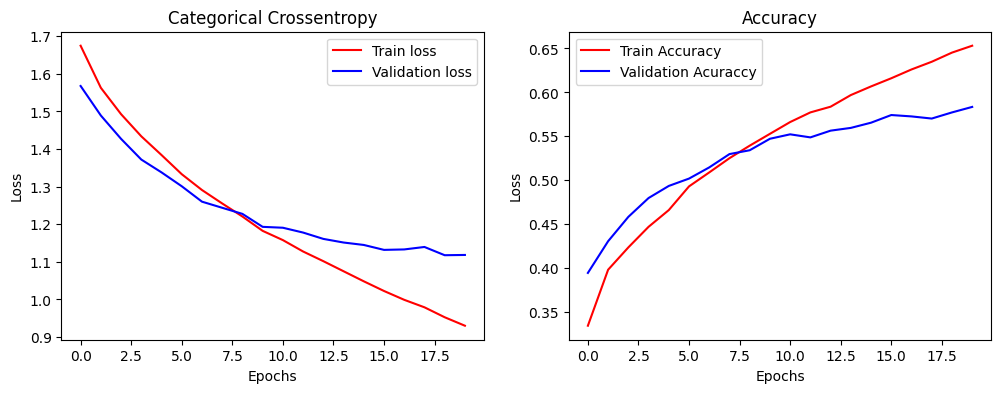

In [29]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(resumen.history['loss'],c='r',label='Train loss')
ax.plot(resumen.history['val_loss'],c='b',label='Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Categorical Crossentropy')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.plot(resumen.history['accuracy'],c='r',label='Train Accuracy')
ax.plot(resumen.history['val_accuracy'],c='b',label='Validation Acuraccy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Accuracy')
ax.legend()

plt.legend()
plt.show()

In [33]:
class myCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.62):
      self.model.stop_training = True
      print("\nACCURACY ALCANZADA!\n")

mi_callback = myCallBack()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)


resumen2 = modelo.fit(training_images,validation_data=validation_images,epochs = 20, callbacks=[mi_callback, reduce_lr])


Epoch 1/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7314 - loss: 0.7383 - val_accuracy: 0.5912 - val_loss: 1.1126 - learning_rate: 5.0000e-05
Epoch 2/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7380 - loss: 0.7251 - val_accuracy: 0.5959 - val_loss: 1.1169 - learning_rate: 5.0000e-05
Epoch 3/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7386 - loss: 0.7177 - val_accuracy: 0.5992 - val_loss: 1.1234 - learning_rate: 5.0000e-05
Epoch 4/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.7366 - loss: 0.7055 - val_accuracy: 0.5948 - val_loss: 1.1256 - learning_rate: 5.0000e-05
Epoch 5/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7470 - loss: 0.6851 - val_accuracy: 0.6002 - val_loss: 1.1171 - learning_rate: 2.5000e-05
Epoch 6/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7564 - loss: 0.6704 - val_accuracy: 0.6002 - val_loss: 1.1243 - learning_rate: 2.5000e-05
Epoch 7/20
718/718 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step -

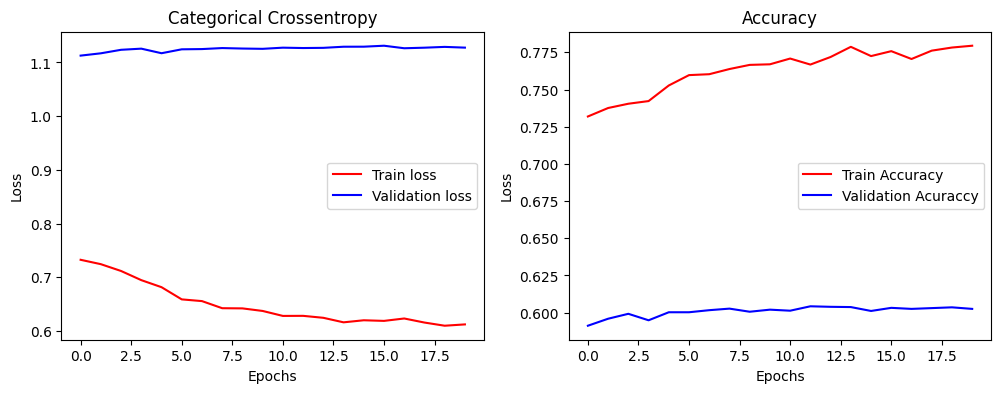

In [34]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(resumen2.history['loss'],c='r',label='Train loss')
ax.plot(resumen2.history['val_loss'],c='b',label='Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Categorical Crossentropy')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.plot(resumen2.history['accuracy'],c='r',label='Train Accuracy')
ax.plot(resumen2.history['val_accuracy'],c='b',label='Validation Acuraccy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Accuracy')
ax.legend()

plt.legend()
plt.show()

In [38]:
images, labels = next(iter(test_images.take(1)))
preds = modelo.predict(images, verbose=False)

pred_classes = np.argmax(preds, axis=1)

true_classes = labels.numpy()
true_classes = np.argmax(true_classes, axis=1)

print("Predicciones:", pred_classes[:10])
print("Reales:      ", true_classes[:10])


Predicciones: [3 6 3 0 2 2 1 0 2 0]
Reales:       [3 6 3 0 5 3 1 0 1 5]


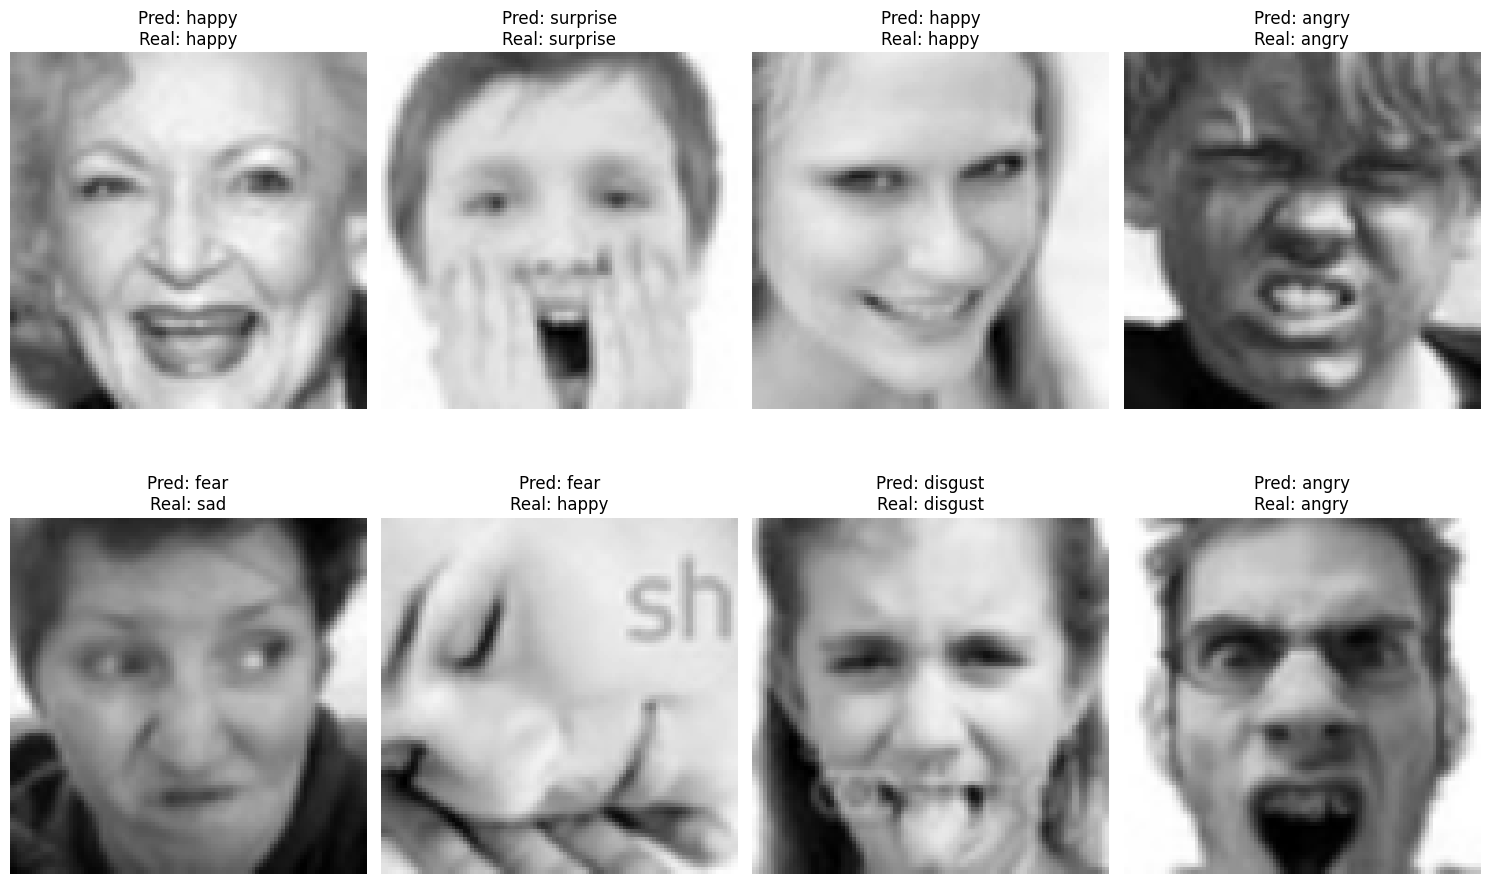

In [43]:
resize_layer = Resizing(96, 96)

plt.figure(figsize=(15, 10))

true_classes = np.argmax(labels.numpy(), axis=1)
pred_classes = np.argmax(preds, axis=1)

for i in range(8):
    plt.subplot(2, 4, i + 1)

    img = resize_layer(images[i]).numpy().squeeze().astype("uint8")

    plt.imshow(img, cmap="gray")
    plt.title(f"Pred: {idx_to_emotion[pred_classes[i]]}\nReal: {idx_to_emotion[true_classes[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [44]:
ACC = modelo.evaluate(test_images, verbose=False)
print('Test Loss: ',ACC[0])
print('Test Accuracy: ',ACC[1])

Test Loss:  1.1184505224227905
Test Accuracy:  0.6061577200889587


In [45]:
y_true = []
y_pred = []

for images, labels in test_images:
    preds = modelo.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

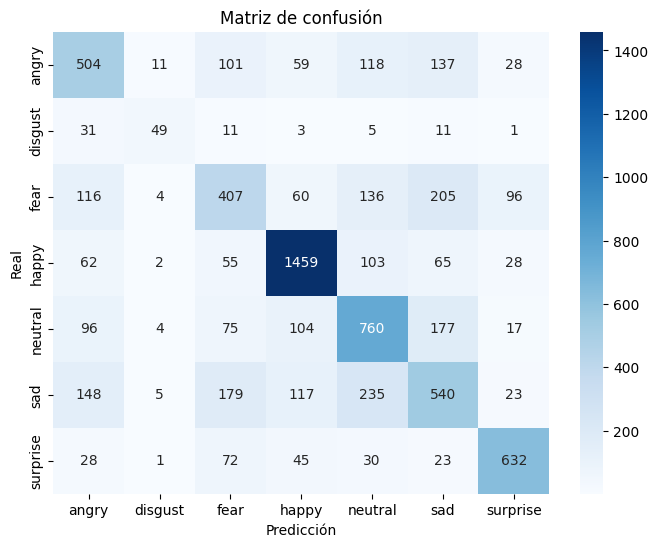

              precision    recall  f1-score   support

       angry       0.51      0.53      0.52       958
     disgust       0.64      0.44      0.52       111
        fear       0.45      0.40      0.42      1024
       happy       0.79      0.82      0.81      1774
     neutral       0.55      0.62      0.58      1233
         sad       0.47      0.43      0.45      1247
    surprise       0.77      0.76      0.76       831

    accuracy                           0.61      7178
   macro avg       0.60      0.57      0.58      7178
weighted avg       0.60      0.61      0.60      7178



In [48]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=idx_to_emotion.values(),
            yticklabels=idx_to_emotion.values())
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.show()

print(classification_report(y_true, y_pred, target_names=idx_to_emotion.values()))


## Con tratamiento de datos desbalanceados

In [49]:
train_dir = "train"
test_dir = "test"

training_images = image_dataset_from_directory(train_dir,
                                                color_mode='grayscale',
                                                label_mode='categorical',
                                                batch_size=32,
                                                image_size=(144,144),
                                                shuffle=True,
                                                seed=42,
                                                validation_split=0.2,
                                                subset='training')

validation_images = image_dataset_from_directory(train_dir,
                                                color_mode='grayscale',
                                                label_mode='categorical',
                                                batch_size=32,
                                                image_size=(144,144),
                                                shuffle=True,
                                                seed=42,
                                                validation_split=0.2,
                                                subset='validation')

test_images = image_dataset_from_directory(test_dir,
                                           color_mode='grayscale',
                                           label_mode='categorical',
                                           batch_size=32,
                                           image_size=(144,144),
                                           shuffle=True,
                                           seed=42)


Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
Found 7178 files belonging to 7 classes.


In [54]:
class_names = training_images.class_names
print(class_names)

idx_to_emotion = {i: name for i, name in enumerate(class_names)}
print(idx_to_emotion)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [52]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

def augment(x, y):
    return data_augmentation(x), y

train_ds = training_images.map(augment)

In [58]:
y_true = []
for _, labels in training_images.unbatch():
    y_true.append(labels.numpy())

y_true = np.array(y_true)

if y_true.ndim > 1 and y_true.shape[1] > 1:
    y_true = np.argmax(y_true, axis=1)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_true),
    y=y_true
)
class_weights = dict(enumerate(class_weights))

print("Pesos por clase:")

for key, value in class_weights.items():
    print(f"Clase {key}: {value}")

Pesos por clase:
Clase 0: 1.0196217703986505
Clase 1: 9.03896103896104
Clase 2: 0.998825831702544
Clase 3: 0.5644491410877098
Clase 4: 0.8275265717888669
Clase 5: 0.8558014755197854
Clase 6: 1.3177280550774526


In [64]:
images, labels = next(iter(training_images))
print("Shape imágenes:", images.shape)
print("Shape etiquetas:", labels.shape)
print("Ejemplo etiqueta:", labels[0])

Shape imágenes: (32, 144, 144, 1)
Shape etiquetas: (32, 7)
Ejemplo etiqueta: tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32)


In [70]:
modelo2 = Sequential()

modelo2.add(Input(shape=(144,144,1)))

modelo2.add(Rescaling(1./255))

modelo2.add(Conv2D(filters=32, kernel_size=(3,3),activation='relu'))
modelo2.add(MaxPooling2D(2,2))
modelo2.add(Conv2D(filters=64, kernel_size=(3,3),activation='relu'))
modelo2.add(MaxPooling2D(2,2))
modelo2.add(Conv2D(filters=128, kernel_size=(3,3),activation='relu'))
modelo2.add(MaxPooling2D(2,2))
modelo2.add(Conv2D(filters=256, kernel_size=(3,3),activation='relu'))
modelo2.add(MaxPooling2D(2,2))

modelo2.add(Dropout(0.5))
modelo2.add(Flatten())
modelo2.add(Dense(256,activation='relu'))
modelo2.add(Dropout(0.25))
modelo2.add(Dense(128,activation='relu'))
modelo2.add(Dropout(0.1))
modelo2.add(Dense(7,activation='softmax'))

modelo2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 144, 144, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 142, 142, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 71, 71, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 69, 69, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     3,211,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,633,159 (13.86 MB)

 Trainable params: 3,633,159 (13.86 MB)

 Non-trainable params: 0 (0.00 B)

In [71]:
LR = 0.0001

opt = Adam(learning_rate=LR)
modelo2.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [72]:
resumen = modelo2.fit(training_images,validation_data=validation_images, class_weight=class_weights,epochs = 25, callbacks=[mi_callback])

Epoch 1/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - accuracy: 0.1703 - loss: 1.9223 - val_accuracy: 0.2782 - val_loss: 1.8063
Epoch 2/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.2857 - loss: 1.7880 - val_accuracy: 0.3485 - val_loss: 1.6988
Epoch 3/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.3550 - loss: 1.6663 - val_accuracy: 0.4128 - val_loss: 1.5673
Epoch 4/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.3958 - loss: 1.5616 - val_accuracy: 0.4485 - val_loss: 1.4728
Epoch 5/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.4306 - loss: 1.4802 - val_accuracy: 0.4557 - val_loss: 1.4550
Epoch 6/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.4484 - loss: 1.4031 - val_accuracy: 0.4715 - val_loss: 1.4007
Epoch 7/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.4759 - loss: 1.3382 - val_accuracy: 0.4722 - val_loss: 1.3705
Epoch 8/25
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.4927 - loss: 1.2650 - 

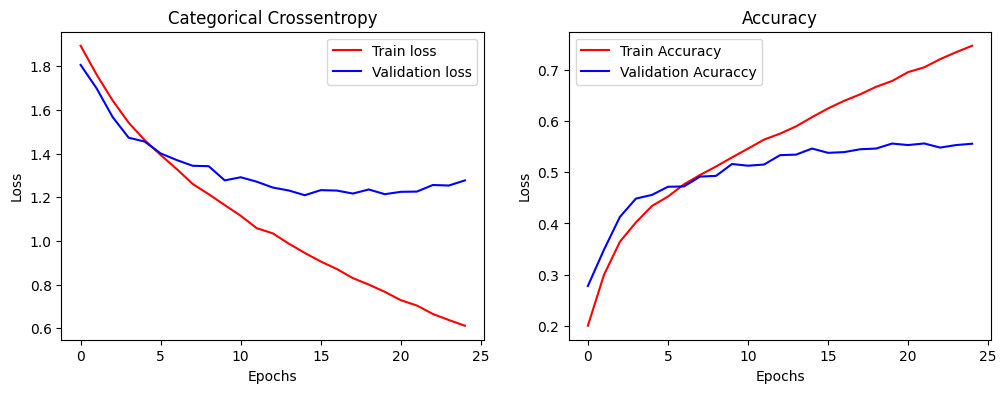

In [74]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,2,1)
ax.plot(resumen.history['loss'],c='r',label='Train loss')
ax.plot(resumen.history['val_loss'],c='b',label='Validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Categorical Crossentropy')
ax.legend()
ax = fig.add_subplot(1,2,2)
ax.plot(resumen.history['accuracy'],c='r',label='Train Accuracy')
ax.plot(resumen.history['val_accuracy'],c='b',label='Validation Acuraccy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Accuracy')
ax.legend()

plt.legend()
plt.show()

In [75]:
class myCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.60):
      self.model.stop_training = True
      print("\nACCURACY ALCANZADA!\n")

mi_callback = myCallBack()

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)


resumen2 = modelo2.fit(training_images,validation_data=validation_images,class_weight=class_weights, epochs = 10, callbacks=[mi_callback, reduce_lr])


Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.7611 - loss: 0.5758 - val_accuracy: 0.5584 - val_loss: 1.2884 - learning_rate: 1.0000e-04
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7718 - loss: 0.5509 - val_accuracy: 0.5546 - val_loss: 1.3098 - learning_rate: 1.0000e-04
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.7798 - loss: 0.5289 - val_accuracy: 0.5543 - val_loss: 1.3209 - learning_rate: 1.0000e-04
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.7938 - loss: 0.4926 - val_accuracy: 0.5651 - val_loss: 1.3421 - learning_rate: 5.0000e-05
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.8051 - loss: 0.4664 - val_accuracy: 0.5663 - val_loss: 1.3375 - learning_rate: 5.0000e-05
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - accuracy: 0.8173 - loss: 0.4397 - val_accuracy: 0.5696 - val_loss: 1.3609 - learning_rate: 2.5000e-05
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/ste

In [76]:
images, labels = next(iter(test_images.take(1)))
preds = modelo2.predict(images, verbose=False)

pred_classes = np.argmax(preds, axis=1)

true_classes = labels.numpy()
true_classes = np.argmax(true_classes, axis=1)

print("Predicciones:", pred_classes[:10])
print("Reales:      ", true_classes[:10])


Predicciones: [2 3 0 2 4 3 3 4 5 6]
Reales:       [3 3 0 4 4 3 3 4 5 6]


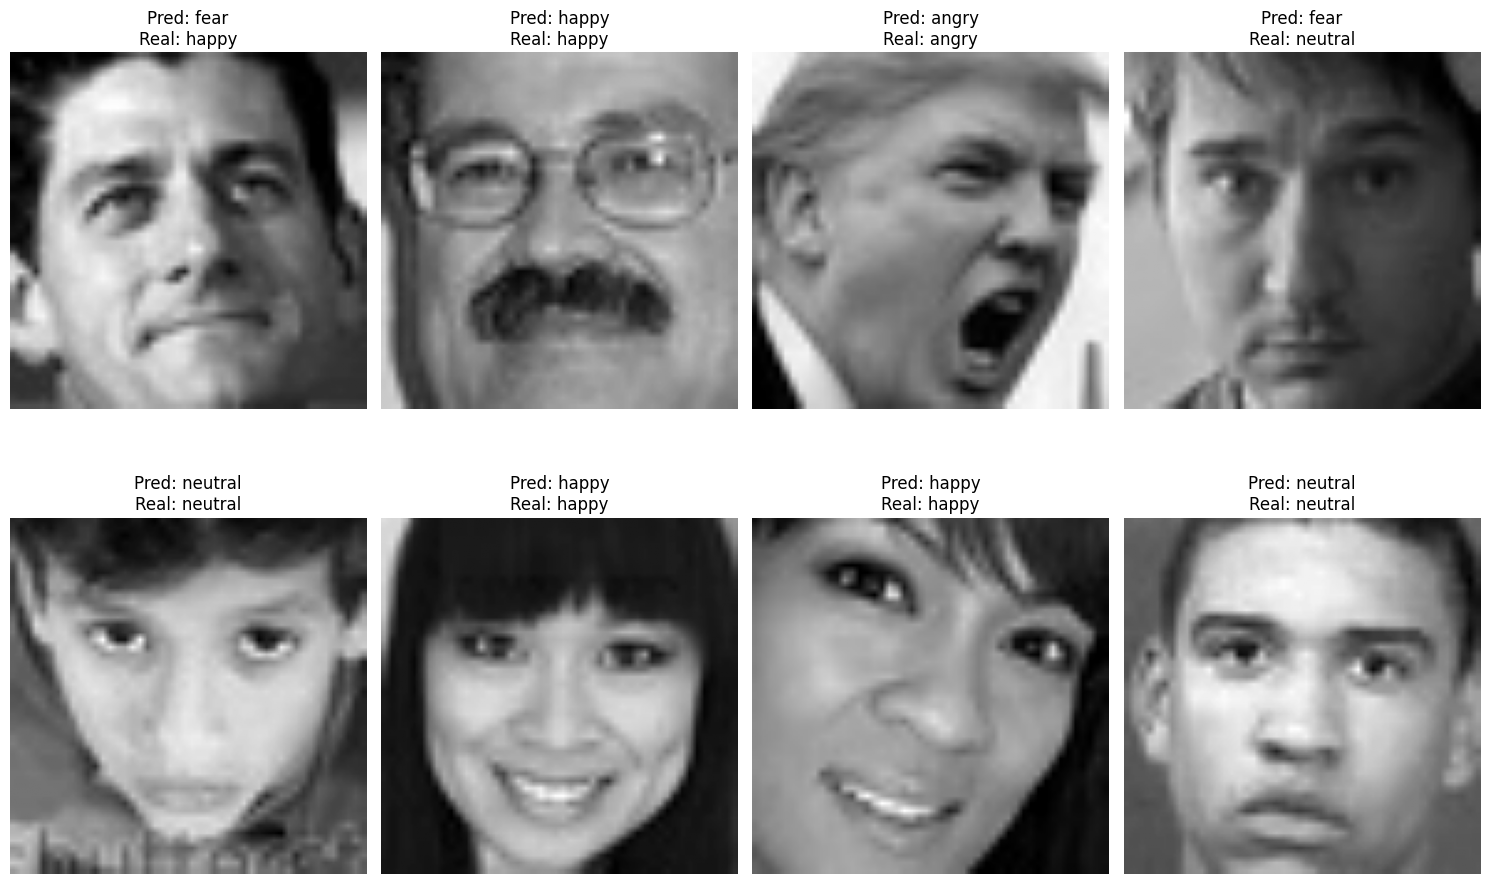

In [78]:
plt.figure(figsize=(15, 10))

true_classes = np.argmax(labels.numpy(), axis=1)
pred_classes = np.argmax(preds, axis=1)

for i in range(8):
    plt.subplot(2, 4, i + 1)

    img = images[i].numpy().squeeze().astype("uint8")

    plt.imshow(img, cmap="gray")
    plt.title(f"Pred: {idx_to_emotion[pred_classes[i]]}\nReal: {idx_to_emotion[true_classes[i]]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [79]:
ACC = modelo2.evaluate(test_images, verbose=False)
print('Test Loss: ',ACC[0])
print('Test Accuracy: ',ACC[1])

y_true = []
y_pred = []

for images, labels in test_images:
    preds = modelo2.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(y_true, y_pred, target_names=idx_to_emotion.values()))

Test Loss:  1.307170033454895
Test Accuracy:  0.5895792841911316
              precision    recall  f1-score   support

       angry       0.47      0.48      0.47       958
     disgust       0.63      0.60      0.62       111
        fear       0.47      0.43      0.45      1024
       happy       0.77      0.77      0.77      1774
     neutral       0.53      0.57      0.55      1233
         sad       0.46      0.46      0.46      1247
    surprise       0.74      0.76      0.75       831

    accuracy                           0.59      7178
   macro avg       0.58      0.58      0.58      7178
weighted avg       0.59      0.59      0.59      7178



## EL MEJOR ERA EL PRIMER MODELO ENTRENADO

In [80]:
modelo.save("modelo_fer2013.keras")